In [1]:
from datetime import datetime, timedelta
from collections import Counter

import numpy as np
np.random.seed(4242)

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn.metrics import (
    f1_score, recall_score, roc_auc_score,
    precision_recall_curve, average_precision_score,
    roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold

import lightgbm as lgb

import tqdm

from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh import extract_features

In [2]:
df = pd.read_csv(
    '../../data/dataset_utf.csv',
    parse_dates=['date']
)

In [3]:
df_clean = df[
    (datetime(2017, 1, 11, 0, 0, 0) <= df.date) &
    ~(
        (datetime(2017, 4, 15, 0, 0, 0) <= df.date) &
        (df.date <= datetime(2017, 4, 15, 23, 59, 50))
    ) &
    ~(
        (datetime(2017, 8, 1, 0, 0, 0) <= df.date) &
        (df.date <= datetime(2017, 8, 1, 23, 59, 50))
    ) &
    ~(
        (datetime(2017, 10, 9, 0, 0, 0) <= df.date) &
        (df.date <= datetime(2017, 10, 9, 23, 59, 50))
    ) &
    (df.date <= datetime(2017, 12, 31, 23, 59, 50))
]
df_clean

date  RF.21304.Ток...213MII904A  \
86399   2017-01-11 00:00:00                        5.0   
86400   2017-01-11 00:00:10                        5.0   
86401   2017-01-11 00:00:20                        5.0   
86402   2017-01-11 00:00:30                        5.1   
86403   2017-01-11 00:00:40                        5.0   
86404   2017-01-11 00:00:50                        4.9   
86405   2017-01-11 00:01:00                        5.1   
86406   2017-01-11 00:01:10                        5.0   
86407   2017-01-11 00:01:20                        5.0   
86408   2017-01-11 00:01:30                        4.9   
86409   2017-01-11 00:01:40                        5.0   
86410   2017-01-11 00:01:50                        5.0   
86411   2017-01-11 00:02:00                        5.0   
86412   2017-01-11 00:02:10                        5.1   
86413   2017-01-11 00:02:20                        5.1   
86414   2017-01-11 00:02:30                        5.0   
86415   2017-01-11 00:02:40                        5.1   
86416   2017-01-11 00:02:50                        5.1   
86417   2017-01-11 00:03:00                        4.9   
86418   2017-01-11 00:03:10                        5.1   
86419   2017-01-11 00:03:20                        5.0   
86420   2017-01-11 00:03:30                        5.0   
86421   2017-01-11 00:03:40                        4.9   
86422   2017-01-11 00:03:50                        5.0   
86423   2017-01-11 00:04:00                        5.1   
86424   2017-01-11 00:04:10                        5.0   
86425   2017-01-11 00:04:20                        5.0   
86426   2017-01-11 00:04:30                        5.1   
86427   2017-01-11 00:04:40                        5.0   
86428   2017-01-11 00:04:50                        5.0   
...                     ...                        ...   
3153569 2017-12-31 23:55:00                        5.0   
3153570 2017-12-31 23:55:10                        5.0   
3153571 2017-12-31 23:55:20                        4.9   
3153572 2017-12-31 23:55:30                        5.0   
3153573 2017-12-31 23:55:40                        5.0   
3153574 2017-12-31 23:55:50                        5.0   
3153575 2017-12-31 23:56:00                        4.9   
3153576 2017-12-31 23:56:10                        4.9   
3153577 2017-12-31 23:56:20                        5.0   
3153578 2017-12-31 23:56:30                        5.0   
3153579 2017-12-31 23:56:40                        5.0   
3153580 2017-12-31 23:56:50                        5.0   
3153581 2017-12-31 23:57:00                        4.9   
3153582 2017-12-31 23:57:10                        5.0   
3153583 2017-12-31 23:57:20                        5.0   
3153584 2017-12-31 23:57:30                        4.9   
3153585 2017-12-31 23:57:40                        5.0   
3153586 2017-12-31 23:57:50                        5.0   
3153587 2017-12-31 23:58:00                        5.0   
3153588 2017-12-31 23:58:10                        4.9   
3153589 2017-12-31 23:58:20                        4.8   
3153590 2017-12-31 23:58:30                        5.0   
3153591 2017-12-31 23:58:40                        4.9   
3153592 2017-12-31 23:58:50                        5.0   
3153593 2017-12-31 23:59:00                        4.9   
3153594 2017-12-31 23:59:10                        4.9   
3153595 2017-12-31 23:59:20                        4.9   
3153596 2017-12-31 23:59:30                        4.9   
3153597 2017-12-31 23:59:40                        4.9   
3153598 2017-12-31 23:59:50                        4.9   

         S.C.ВПУСК.ПП.ДАВЛ...214PI226AA  S.C.ВПУСК.ПП.ДАВЛ...214PI226AB  \
86399                          9.710000                        9.510000   
86400                          9.889999                        9.670000   
86401                          9.920000                        9.690000   
86402                          9.900000                        9.670000   
86403                          9.889999            

In [4]:
# Counter(df_clean.date[df_clean.isnull().any(axis=1)].map(
#     lambda x: (x - datetime(2017, 1, 1, 0, 0, 0)).total_seconds() // 86400))

In [5]:
stops = pd.read_csv('../../data/stops.csv', parse_dates=['date'])
stops = pd.concat([
    pd.read_csv('../../data/good_stops.csv', parse_dates=['date'], index_col=0).date,
    stops.date[stops.type == 'vibrosito']
])
stops.sort_values(inplace=True)
stops = stops.reset_index()

In [6]:
def make_range(df, stop_dt, to_left, to_right):
    left = stop_dt - timedelta(minutes=to_left)
    right = stop_dt + timedelta(minutes=to_right)
    return (left <= df.date) & (df.date <= right)

df_no_stops = df_clean.copy()
for stop_dt in stops.date:
    df_no_stops = df_no_stops[~make_range(df_no_stops, stop_dt, to_left=480, to_right=180)]

In [7]:
def make_false(df_no_stops, minutes):
    random_work = np.random.choice(np.arange(minutes * 6, df_no_stops.shape[0]), 10000)
    dfs = []
    ids = []
    
    for work in tqdm.tqdm_notebook(random_work):
        stop_dt = df_no_stops.iloc[work]['date']
        df = df_no_stops[make_range(df_no_stops, stop_dt, to_left=minutes, to_right=0)].copy()
        if not df.shape[0]:
            continue
        id = stop_dt.to_datetime64().astype(int)
        df['id'] = id
        ids.append(id)
        dfs.append(df)
    
    y = pd.Series(0, index=ids)
    return pd.concat(dfs), y

In [8]:
def make_true(df_with_stops, stops, minutes_before, minutes_in):
    dfs = []
    ids = []
    groups = []

    for stop_dt in tqdm.tqdm_notebook(stops.date[stops.date < datetime(2018, 1, 1, 0, 0, 0)]):
        dts = df_with_stops.date[make_range(df_with_stops, stop_dt, to_left=minutes_in, to_right=0)]
        for dt in dts:
            df = df_with_stops[make_range(df_with_stops, dt, to_left=minutes_before, to_right=0)].copy()
            if not df.shape[0]:
                continue
            id = dt.to_datetime64().astype(int)
            df['id'] = id
            ids.append(id)
            dfs.append(df)
            groups.append(stop_dt.to_datetime64().astype(int))
        
    y = pd.Series(1, index=ids)
    groups = np.array(groups)
    return pd.concat(dfs), y, groups

In [9]:
MAX_ROUNDS = 1000
params = {
    'num_leaves': 2**5 - 1,
    'objective': 'binary',
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'binary',
    'num_threads': 4
}
    
def train(X_train, y_train):
    dtrain = lgb.Dataset(
        X_train, label=y_train,
        categorical_feature=[],
    )
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain], early_stopping_rounds=100, verbose_eval=50
    )
    
    return bst

In [10]:
def train_and_test(X_train, y_train, X_val, y_val):
    dtrain = lgb.Dataset(
        X_train, label=y_train,
        categorical_feature=[],
    )
    dval = lgb.Dataset(
        X_val, label=y_val, reference=dtrain,
        categorical_feature=[])
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=100, verbose_eval=50
    )
    
    bst = train(X_train, y_train)
    predicted = bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS)
    
    return predicted

In [11]:
minutes_before = 60
minutes_in = 5

In [12]:
X_false, y_false = make_false(df_no_stops, minutes_before)

# fix sampling in y_false
y_false = y_false.groupby(level=0).sum()

In [13]:
X_true, y_true, groups_true = make_true(df_clean, stops, minutes_before, minutes_in)

In [14]:
X = pd.concat([X_false, X_true])
y = pd.concat([y_false, y_true])

features_extracted = extract_features(
    X,
    column_sort='date',
    column_id='id',
    default_fc_parameters=MinimalFCParameters()
)

features_extracted.sort_index(inplace=True)
y.sort_index(inplace=True)

Feature Extraction: 100%|██████████| 80/80 [01:17<00:00,  1.03it/s]


In [15]:
Xf_false = features_extracted[features_extracted.index.isin(X_false.id)]
yf_false = y[y.index.isin(y_false.index)]
Xf_true = features_extracted[features_extracted.index.isin(X_true.id)]
yf_true = y[y.index.isin(y_true.index)]

In [16]:
def make_train_val(Xf_false, Xf_true, yf_false, yf_true, groups_true):
    kf = KFold(n_splits=3, shuffle=True)
    gkf = GroupKFold(n_splits=3)
    for (train_index_0, test_index_0), (train_index_1, test_index_1) in zip(
        kf.split(Xf_false, yf_false), gkf.split(Xf_true, yf_true, groups_true)):
        X_train_0, X_test_0 = Xf_false[train_index_0], Xf_false[test_index_0]
        y_train_0, y_test_0 = yf_false[train_index_0], yf_false[test_index_0]
        X_train_1, X_test_1 = Xf_true[train_index_1], Xf_true[test_index_1]
        y_train_1, y_test_1 = yf_true[train_index_1], yf_true[test_index_1]
        X_train = np.vstack([X_train_0, X_train_1])
        y_train = np.hstack([y_train_0, y_train_1])
        X_test = np.vstack([X_test_0, X_test_1])
        y_test = np.hstack([y_test_0, y_test_1])
        
        train_indices = np.arange(X_train.shape[0])
        np.random.shuffle(train_indices)
        X_train = X_train[train_indices, :]
        y_train = y_train[train_indices]
        
        test_indices = np.arange(X_test.shape[0])
        np.random.shuffle(test_indices)
        X_test = X_test[test_indices, :]
        y_test = y_test[test_indices]
        
        yield X_train, y_train, X_test, y_test

In [17]:
recalls = []
f_scores = []
roc_auc_scores = []

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0555516	valid_1's binary_logloss: 0.22349
[100]	training's binary_logloss: 0.00641746	valid_1's binary_logloss: 0.292692
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.0580509	valid_1's binary_logloss: 0.222907


/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0555516
[100]	training's binary_logloss: 0.00641746
[150]	training's binary_logloss: 0.00091219
[200]	training's binary_logloss: 0.000121605
[250]	training's binary_logloss: 1.62923e-05
[300]	training's binary_logloss: 2.87845e-06
[350]	training's binary_logloss: 1.23206e-06
[400]	training's binary_logloss: 8.62111e-07
[450]	training's binary_logloss: 7.19537e-07
[500]	training's binary_logloss: 6.31417e-07
[550]	training's binary_logloss: 5.72608e-07
[600]	training's binary_logloss: 5.3723e-07
[650]	training's binary_logloss: 5.11929e-07
[700]	training's binary_logloss: 4.91567e-07
[750]	training's binary_logloss: 4.72537e-07
[800]	training's binary_logloss: 4.55276e-07
[850]	training's binary_logloss: 4.39814e-07
[900]	training's binary_logloss: 4.2544e-07
[950]	training's binary_logloss: 4.12417e-07
[1000]	training's binary_logloss: 4.00025e-07
Did not meet early stopping. Best iteration

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0521682	valid_1's binary_logloss: 0.26094
[100]	training's binary_logloss: 0.00611026	valid_1's binary_logloss: 0.351226
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0754439	valid_1's binary_logloss: 0.257041


/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0521682
[100]	training's binary_logloss: 0.00611026
[150]	training's binary_logloss: 0.000818368
[200]	training's binary_logloss: 0.000103255
[250]	training's binary_logloss: 1.33507e-05
[300]	training's binary_logloss: 2.57413e-06
[350]	training's binary_logloss: 1.16138e-06
[400]	training's binary_logloss: 8.15858e-07
[450]	training's binary_logloss: 6.80628e-07
[500]	training's binary_logloss: 6.08725e-07
[550]	training's binary_logloss: 5.62735e-07
[600]	training's binary_logloss: 5.31877e-07
[650]	training's binary_logloss: 5.08386e-07
[700]	training's binary_logloss: 4.86973e-07
[750]	training's binary_logloss: 4.67508e-07
[800]	training's binary_logloss: 4.49887e-07
[850]	training's binary_logloss: 4.33901e-07
[900]	training's binary_logloss: 4.19508e-07
[950]	training's binary_logloss: 4.06277e-07
[1000]	training's binary_logloss: 3.9395e-07
Did not meet early stopping. Best iterati

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0552466	valid_1's binary_logloss: 0.226317
[100]	training's binary_logloss: 0.00670056	valid_1's binary_logloss: 0.318363
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.0720847	valid_1's binary_logloss: 0.22528


/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0552466
[100]	training's binary_logloss: 0.00670056
[150]	training's binary_logloss: 0.000979327
[200]	training's binary_logloss: 0.000138654
[250]	training's binary_logloss: 1.9386e-05
[300]	training's binary_logloss: 3.42485e-06
[350]	training's binary_logloss: 1.30695e-06
[400]	training's binary_logloss: 8.74326e-07
[450]	training's binary_logloss: 7.12517e-07
[500]	training's binary_logloss: 6.17135e-07
[550]	training's binary_logloss: 5.62462e-07
[600]	training's binary_logloss: 5.32822e-07
[650]	training's binary_logloss: 5.09879e-07
[700]	training's binary_logloss: 4.89339e-07
[750]	training's binary_logloss: 4.70562e-07
[800]	training's binary_logloss: 4.53798e-07
[850]	training's binary_logloss: 4.38179e-07
[900]	training's binary_logloss: 4.24306e-07
[950]	training's binary_logloss: 4.11695e-07
[1000]	training's binary_logloss: 4.00316e-07
Did not meet early stopping. Best iterati

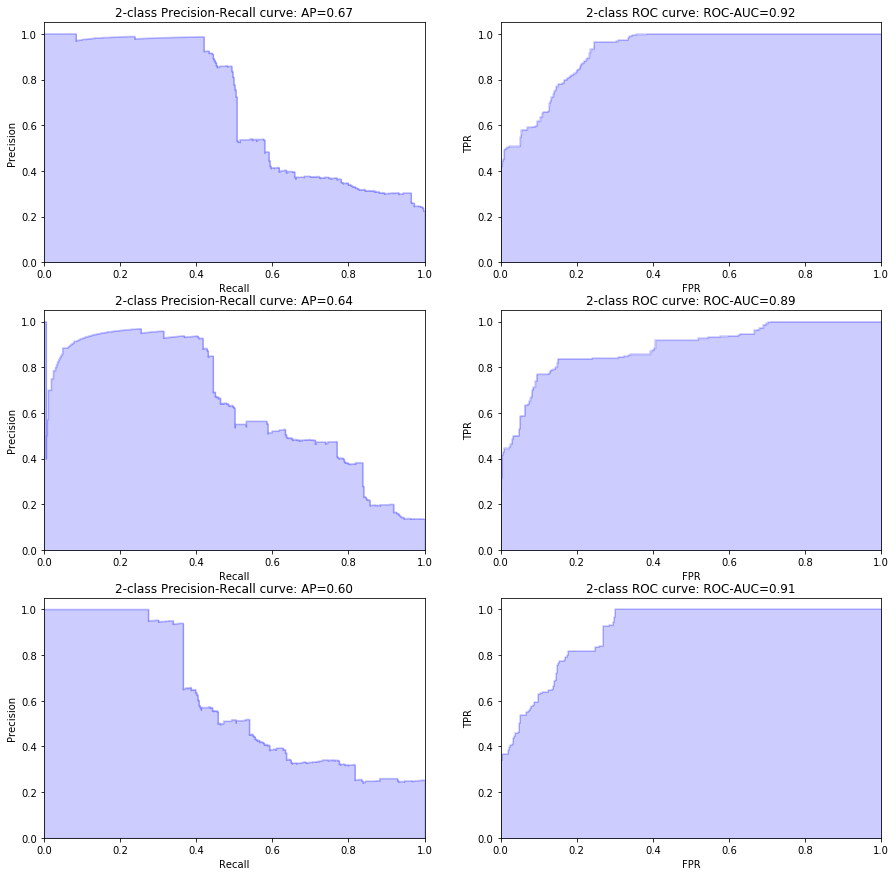

In [18]:
f, axarr = plt.subplots(3, 2, figsize=(15, 15))

for i, (X_train, y_train, X_val, y_val) in enumerate(
    make_train_val(Xf_false.values, Xf_true.values, yf_false.values, yf_true.values, groups_true)):
    predicted = train_and_test(X_train, y_train, X_val, y_val)
    roc_auc_scores.append(roc_auc_score(y_val, predicted))

    precision, recall, _ = precision_recall_curve(y_val, predicted)

    axarr[i, 0].step(recall, precision, color='b', alpha=0.2,
             where='post')
    axarr[i, 0].fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    axarr[i, 0].set_xlabel('Recall')
    axarr[i, 0].set_ylabel('Precision')
    axarr[i, 0].set_ylim([0.0, 1.05])
    axarr[i, 0].set_xlim([0.0, 1.0])
    axarr[i, 0].set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision_score(y_val, predicted)))

    fpr, tpr, _ = roc_curve(y_val, predicted)

    axarr[i, 1].step(fpr, tpr, color='b', alpha=0.2,
             where='post')
    axarr[i, 1].fill_between(fpr, tpr, step='post', alpha=0.2,
                     color='b')

    axarr[i, 1].set_xlabel('FPR')
    axarr[i, 1].set_ylabel('TPR')
    axarr[i, 1].set_ylim([0.0, 1.05])
    axarr[i, 1].set_xlim([0.0, 1.0])
    axarr[i, 1].set_title('2-class ROC curve: ROC-AUC={0:0.2f}'.format(
              roc_auc_score(y_val, predicted)))

    predicted = (predicted > 0.5).astype(np.int32)
    f_scores.append(f1_score(y_val, predicted.astype(np.bool)))
    recalls.append(recall_score(y_val, predicted.astype(np.bool)))

print("F1:     ", f_scores)
print("Recall: ", recalls)
print("ROC-AUC:", roc_auc_scores)
print('Mean F1:     ', np.mean(f_scores))
print('Mean recall: ', np.mean(recalls))
print('Mean roc-auc:', np.mean(roc_auc_scores))

In [20]:
Xf_full = np.vstack([Xf_false.values, Xf_true.values])
yf_full = np.hstack([yf_false.values, yf_true.values])
        
full_indices = np.arange(Xf_full.shape[0])
np.random.shuffle(full_indices)
Xf_full = Xf_full[full_indices, :]
yf_full = yf_full[full_indices]

In [21]:
bst = train(features_extracted.values, y.values)
# bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS)

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0540222
[100]	training's binary_logloss: 0.00657749
[150]	training's binary_logloss: 0.000949614
[200]	training's binary_logloss: 0.000139137
[250]	training's binary_logloss: 2.12476e-05
[300]	training's binary_logloss: 3.71237e-06
[350]	training's binary_logloss: 1.25017e-06
[400]	training's binary_logloss: 7.63071e-07
[450]	training's binary_logloss: 5.96248e-07
[500]	training's binary_logloss: 5.04851e-07
[550]	training's binary_logloss: 4.55217e-07
[600]	training's binary_logloss: 4.17329e-07
[650]	training's binary_logloss: 3.90079e-07
[700]	training's binary_logloss: 3.7234e-07
[750]	training's binary_logloss: 3.5841e-07
[800]	training's binary_logloss: 3.48765e-07
[850]	training's binary_logloss: 3.39511e-07
[900]	training's binary_logloss: 3.30913e-07
[950]	training's binary_logloss: 3.22691e-07
[1000]	training's binary_logloss: 3.14807e-07
Did not meet early stopping. Best iteratio

In [22]:
bst.save_model('model-lookahead.bin')

In [12]:
model = lgb.Booster(model_file='model-lookahead.bin')

def predict_one(model, data):
    X = data.copy()
    X['id'] = 0
    features_extracted = extract_features(
        X,
        column_sort='date',
        column_id='id',
        default_fc_parameters=MinimalFCParameters(),
        disable_progressbar=True
    )
    
    pred = model.predict(features_extracted.values, num_iteration=model.best_iteration or MAX_ROUNDS)
    return pred[0]

predict_one(model, df_clean[100500:100500+6*minutes_before])

1.9933531057647434e-09

In [13]:
!pwd

/notebooks/oilstone_sibur/oilstone_sibur_20052018/notebooks


In [14]:
def predict_many(model, data):
    X = data.copy()
    features_extracted = extract_features(
        X,
        column_sort='date',
        column_id='id',
        default_fc_parameters=MinimalFCParameters()
    )
    
    pred = model.predict(features_extracted.values, num_iteration=model.best_iteration or MAX_ROUNDS)
    return pred

def make_test_period(df_all, minutes):
    dfs = []
    ids = []
    
    start = df_all.date.iloc[0] + timedelta(minutes=minutes)
    
    for stop_dt in tqdm.tqdm_notebook(df_all.date[df_all.date >= start]):
        df = df_all[make_range(df_all, stop_dt, to_left=minutes, to_right=0)].copy()
        if not df.shape[0]:
            continue
        df['id'] = stop_dt.to_datetime64().astype(int)
        dfs.append(df)
    
    return pd.concat(dfs)

df_2017_12_15 = df_clean[
    (datetime(2017, 12, 15, 0, 0, 0) <= df_clean.date) &
    (df_clean.date < datetime(2017, 12, 16, 0, 0, 0))
]

test_period = make_test_period(df_2017_12_15, 60)
predictions = predict_many(model, test_period)

Feature Extraction: 100%|██████████| 80/80 [00:59<00:00,  1.35it/s]


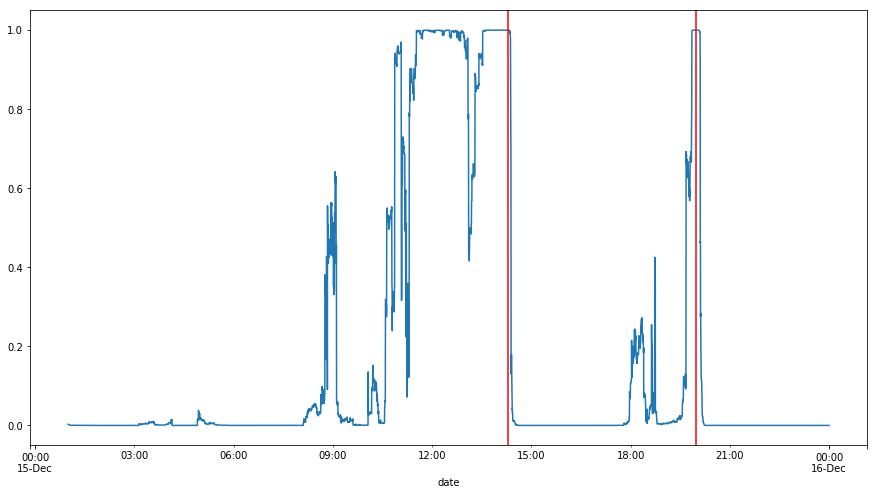

In [15]:
plt.figure(figsize=(15, 8))

timestamps = df_2017_12_15.date[df_2017_12_15.date >= datetime(2017, 12, 15, 1, 0, 0)]

pd.Series(
    predictions,
    index=timestamps
).plot()

dec15_stops = [
    datetime(2017, 12, 15, 14, 17, 0),
    datetime(2017, 12, 15, 19, 58, 0)
]

for stop in dec15_stops: 
    plt.gca().axvline(stop, ymin=0, ymax=1, color='r')

In [33]:
import seaborn as sns
import plotly
from plotly import tools
from plotly.offline import iplot
from plotly.graph_objs import Scatter, Layout, Bar, Histogram, Figure
plotly.offline.init_notebook_mode(connected=True)

In [38]:
iplot([Scatter(y=predictions)])